In [1]:
#%% packages
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
#%% data import 


In [3]:
twitter_file = 'data/Tweets.csv'
df = pd.read_csv(twitter_file).dropna()
df


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:

# %% get class values based on categories
cat_id = {'neutral': 1, 
          'negative': 0, 
          'positive': 2}

df['class'] = df['sentiment'].map(cat_id)


In [7]:
df

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,2
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,2


In [5]:

#%% Hyperparameters
BATCH_SIZE = 512
NUM_EPOCHS = 80


In [6]:

#%% separate independent and dependent features
X = df['text'].values
y = df['class'].values
# %% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=123)
print(f"X train: {X_train.shape}, y train: {y_train.shape}\nX test: {X_test.shape}, y test: {y_test.shape}")
#%%


X train: (13740,), y train: (13740,)
X test: (13740,), y test: (13740,)


In [ ]:

one_hot = CountVectorizer()
X_train_onehot = one_hot.fit_transform(X_train)
X_test_onehot = one_hot.transform(X_test)


In [8]:
X_train_onehot

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 157703 stored elements and shape (13740, 17321)>

In [9]:

#%% Dataset Class
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

train_ds = SentimentData(X= X_train_onehot, y = y_train)
test_ds = SentimentData(X_test_onehot, y_test)



In [10]:

# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)


In [11]:

# %% Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x



In [12]:

#%% Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES = X_train_onehot.shape[1], NUM_CLASSES = 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())


In [13]:

# %% Model Training

train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())
        
        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")


Epoch 0, Loss: 29.236234664916992
Epoch 1, Loss: 27.77746295928955
Epoch 2, Loss: 25.94657552242279
Epoch 3, Loss: 23.97579801082611
Epoch 4, Loss: 22.046432495117188
Epoch 5, Loss: 20.25182795524597
Epoch 6, Loss: 18.639379262924194
Epoch 7, Loss: 17.1963329911232
Epoch 8, Loss: 15.914549350738525
Epoch 9, Loss: 14.786477625370026
Epoch 10, Loss: 13.782835364341736
Epoch 11, Loss: 12.890697598457336
Epoch 12, Loss: 12.09499841928482
Epoch 13, Loss: 11.383168548345566
Epoch 14, Loss: 10.740680038928986
Epoch 15, Loss: 10.158290982246399
Epoch 16, Loss: 9.617076098918915
Epoch 17, Loss: 9.136551171541214
Epoch 18, Loss: 8.691159933805466
Epoch 19, Loss: 8.291215240955353
Epoch 20, Loss: 7.907257094979286
Epoch 21, Loss: 7.564870178699493
Epoch 22, Loss: 7.242555201053619
Epoch 23, Loss: 6.940300479531288
Epoch 24, Loss: 6.654628187417984
Epoch 25, Loss: 6.395754456520081
Epoch 26, Loss: 6.1431241780519485
Epoch 27, Loss: 5.918775305151939
Epoch 28, Loss: 5.701365023851395
Epoch 29, Loss

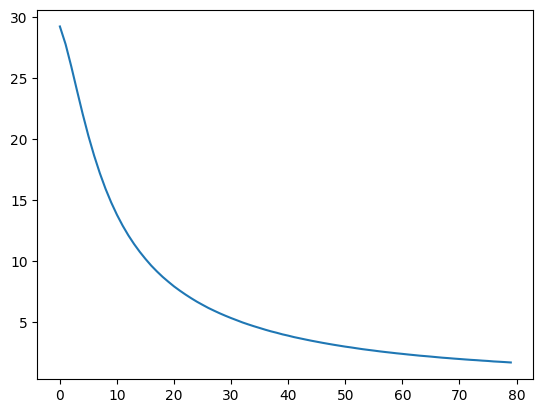

In [14]:

# %%
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()


In [15]:

# %% Model Evaluation
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)


In [16]:
# %% 
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()


In [17]:

# %%
acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."
# %%


'The accuracy of the model is 63.4%.'

In [18]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")


Naive Classifier: 41.0 %


<Axes: >

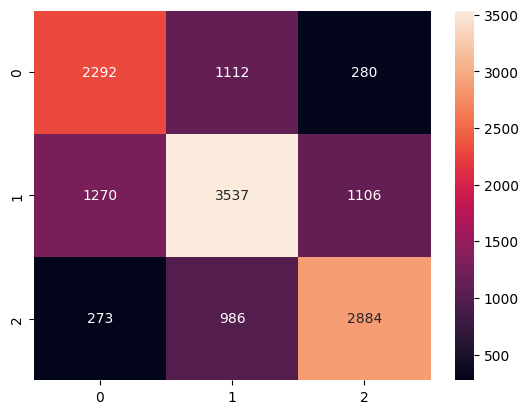

: 

In [19]:

# %% Confusion Matrix
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")
# %%
